## Tutorial of using CytoEMD to characterize the cytometry samples.

In [1]:
import warnings
warnings.filterwarnings("ignore")

from cytoemd import CytoEMD
from cytoemd import knn_purity

import numpy as np
import pandas as pd
import scanpy as sc
import umap

from sklearn.metrics import (
    roc_curve, auc
)

from collections import OrderedDict, defaultdict
from sklearn import preprocessing
from anndata import read_h5ad, AnnData

import matplotlib.pyplot as plt
from matplotlib.pyplot import rc_context
%matplotlib inline
%config InlineBackend.figure_format='retina'

### Read the data and perform pre-processing

In [2]:
adata = read_h5ad("../data/bcr_xl.h5ad")
marker_in_use = ['CD3', 'CD45', 'pNFkB', 'pp38', 'CD4', 'CD20', 'CD33', 'pStat5', 'CD123', 'pAkt', 'pStat1', 'pSHP2',
         'pZap70', 'pStat3', 'CD14', 'pSlp76', 'pBtk', 'pPlcg2', 'pErk', 'pLat', 'IgM', 'pS6', 'HLA-DR', 'CD7']
adata.var.index = adata.var['pns_label']
adata.var.index.name = 'index'
adata = adata[:,marker_in_use]

co_factor = 5.
# set seed for reproducibility
seed = 0

adata.X = np.arcsinh(adata.X / co_factor)

In [3]:
adata_list = [adata[adata.obs['fcs_files'] == sample, :] for sample in adata.obs['fcs_files'].unique()]
sample_meta_list = [_adata.obs[['fcs_files', 'obs_ann_file', 'phenotype']].iloc[0].T for _adata in adata_list]
sample_meta = pd.concat(sample_meta_list, axis=1).T

In [4]:
adata.obs.head()

,fcs_files,obs_ann_file,phenotype,population
1-1,PBMC8_30min_patient1_BCR-XL.fcs,population_IDs_patient1_BCR-XL.csv,BCR-XL,CD4 T-cells
1-2,PBMC8_30min_patient1_BCR-XL.fcs,population_IDs_patient1_BCR-XL.csv,BCR-XL,CD4 T-cells
1-3,PBMC8_30min_patient1_BCR-XL.fcs,population_IDs_patient1_BCR-XL.csv,BCR-XL,NK cells
1-4,PBMC8_30min_patient1_BCR-XL.fcs,population_IDs_patient1_BCR-XL.csv,BCR-XL,CD4 T-cells
1-5,PBMC8_30min_patient1_BCR-XL.fcs,population_IDs_patient1_BCR-XL.csv,BCR-XL,CD8 T-cells


### Create the model and fit the data

In [5]:
%%time
model = CytoEMD(emd_type='UMAP', random_state=0, use_fast=True, n_cpus=4)
embeddings = model.fit_transform(adata_list)

100%|█████████████████████████████████████████| 120/120 [00:01<00:00, 92.99it/s]


CPU times: user 3.41 s, sys: 92.3 ms, total: 3.5 s
Wall time: 4.63 s


### Umap of different samples

... storing 'phenotype' as categorical


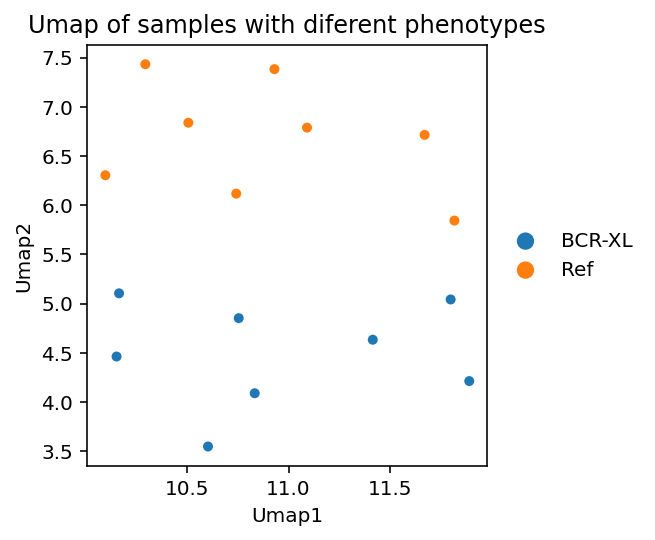

In [6]:
sample_adata = AnnData(embeddings, obs=sample_meta, var=pd.DataFrame(index=['Umap1', 'Umap2']))
with rc_context({'figure.figsize': (4, 4)}):
    sc.pl.scatter(sample_adata, x='Umap1', y='Umap2', color='phenotype', title='Umap of samples with diferent phenotypes', size=100)
# sample_adata.write("../results/bcr_xl_cytoemd.h5ad", compression='gzip')

### Calculate the predicted probabilities w.r.t. phenotype

In [7]:
# prepare the params of meld
sample_labels = np.array(sample_meta['phenotype'].tolist())
meld_kwargs = {'beta': 10, 'sample_normalize': False, 'knn': 4}

scaler = preprocessing.StandardScaler().fit(embeddings)
embeddings = scaler.transform(embeddings)

# predict the predicted under the phenotype (normalized to 1)
pred_prob = model.predict_prob(embeddings, sample_labels, meld_kwargs)
pred_prob.head()

Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...


,BCR-XL,Ref
0,0.731855,0.268145
1,0.274157,0.725843
2,0.717205,0.282795
3,0.297831,0.702169
4,0.623867,0.376133


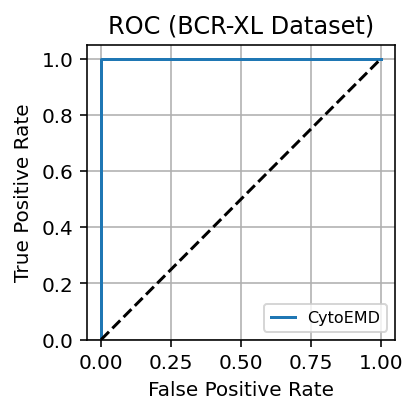

In [8]:
### Plot the ROC Curve
fpr, tpr, thres = roc_curve(
    sample_labels, pred_prob['BCR-XL'], pos_label='BCR-XL'
)
auc_score = auc(fpr, tpr)

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(fpr, tpr, '-', label='CytoEMD')
ax.plot([0,1], [0,1], 'k--')

ax.set_ylim([0.0, 1.05])
ax.set_xlabel("False Positive Rate", fontsize=10)
ax.set_ylabel("True Positive Rate", fontsize=10)
ax.set_title('ROC (BCR-XL Dataset)', fontsize=12)
ax.grid(":")
ax.legend(loc='best', handlelength=1.5, fontsize=8)
plt.tight_layout()
plt.show()

### Use kNN-purity to quantify the results of embeddings

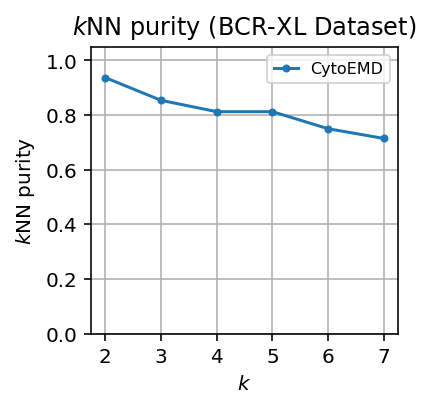

In [9]:
### Plot the KNN purity
label_ids = np.array([1 if lbl == 'BCR-XL' else 0 for lbl in sample_labels])

ks = list(range(2, 8))
knn_purity_score = []

for k in ks:
    knn_purity_score.append(knn_purity(embeddings, label_ids, k))

fig, ax = plt.subplots(1, 1, figsize=(3, 3))
ax.plot(ks, knn_purity_score, marker='.', label='CytoEMD')

ax.set_ylim([0.0, 1.05])
ax.set_xticks([2, 3, 4, 5, 6, 7])
ax.set_xlabel(r"$k$", fontsize=10)
ax.set_ylabel(r"$k$NN purity", fontsize=10)
ax.set_title(r'$k$NN purity (BCR-XL Dataset)', fontsize=12)
ax.grid(":")
ax.legend(loc='best', handlelength=1.5, fontsize=8)
plt.tight_layout()
plt.show()

### Rank the markers using cross entropy score

In [10]:
# calculate the ce score for each marker
ce_score = model.rank_markers(adata_list, sample_labels, meld_kwargs=meld_kwargs)
### sort the cross entropy score
ce_score = OrderedDict(sorted(ce_score.items(), key=lambda x: x[1]))
# print ce_score (lower is more significant)
print(ce_score)

Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating

In [11]:
### create data frame
ce_df = defaultdict(list)
for k, v in ce_score.items():
    ce_df['Marker'].append(k)
    ce_df['Cross Entropy'].append(v)
ce_df = pd.DataFrame(ce_df)

In [12]:
ce_df.head()

,Marker,Cross Entropy
0,CD20,-0.000000
1,pBtk,0.136494
2,CD7,0.199877
3,pNFkB,0.262426
4,pSlp76,0.322479


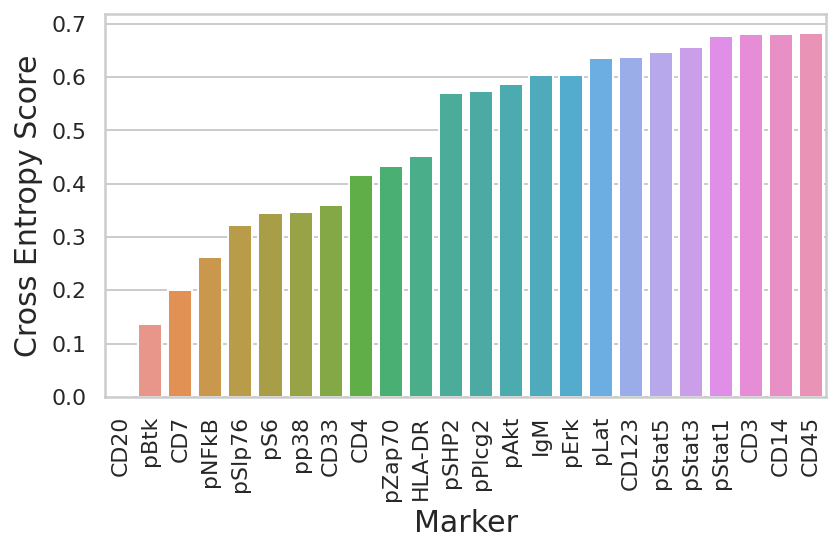

In [13]:
import seaborn as sns
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Marker", y='Cross Entropy', data=ce_df)

ax.set_xlabel("Marker", fontsize=15)
ax.set_ylabel("Cross Entropy Score", fontsize=15)
ax.set_xticklabels(ce_df['Marker'], rotation=90)

plt.tight_layout()
plt.show()

Trying to set attribute `.obs` of view, copying.
... storing 'patient_id' as categorical


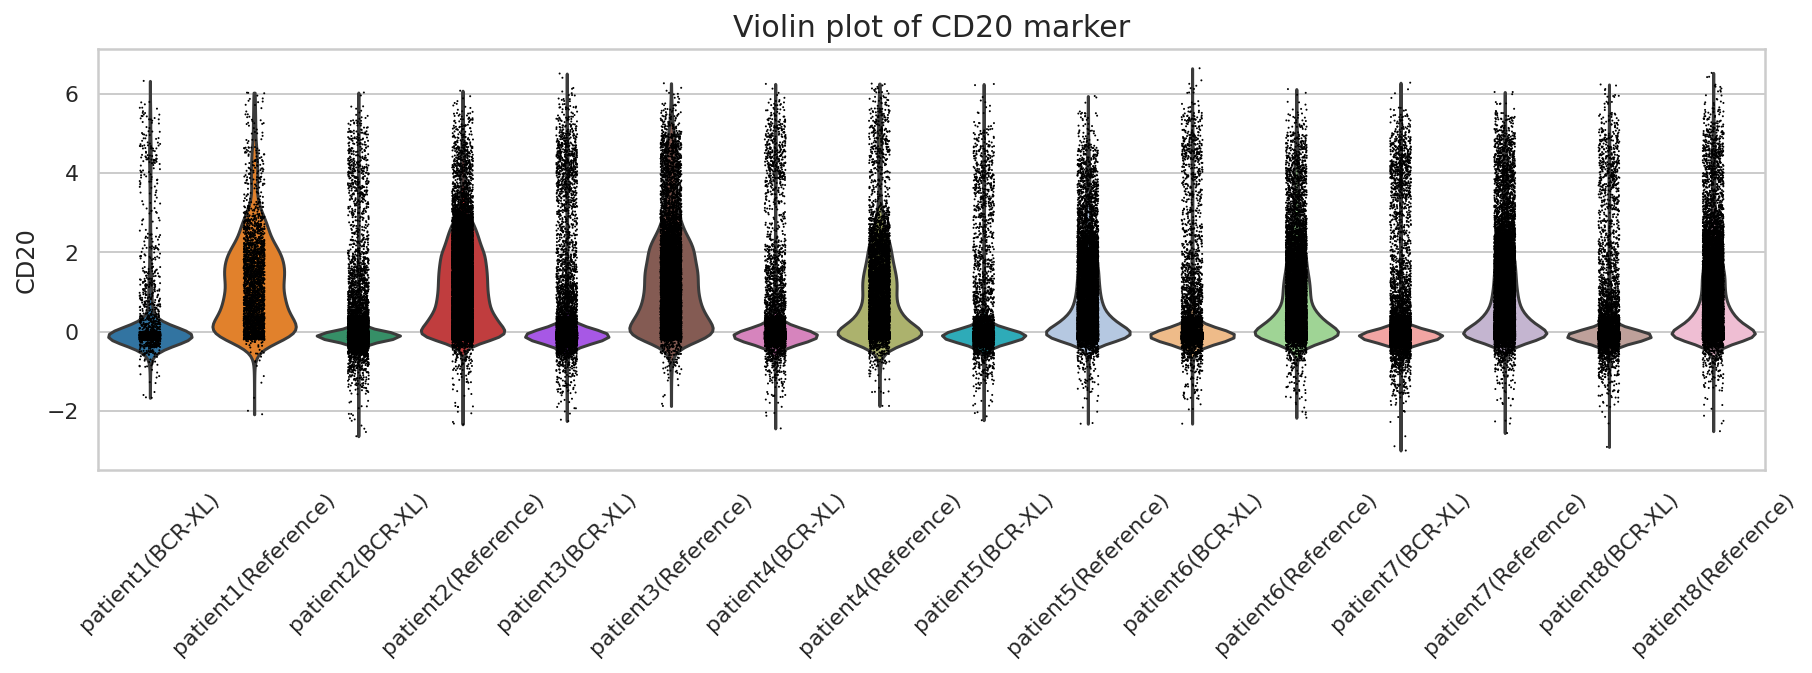

In [14]:
fcs_files = adata.obs['fcs_files'].tolist()
adata.obs['patient_id'] = ["{}({})".format(f.split('_')[2], f.split('_')[3].strip('.fcs')) for f in fcs_files]
with rc_context({'figure.figsize': (12, 4)}):
    ax = sc.pl.violin(adata, ['CD20'], groupby='patient_id', rotation=45, show=False)
    ax.set_title('Violin plot of CD20 marker', fontsize=15)
    plt.show()

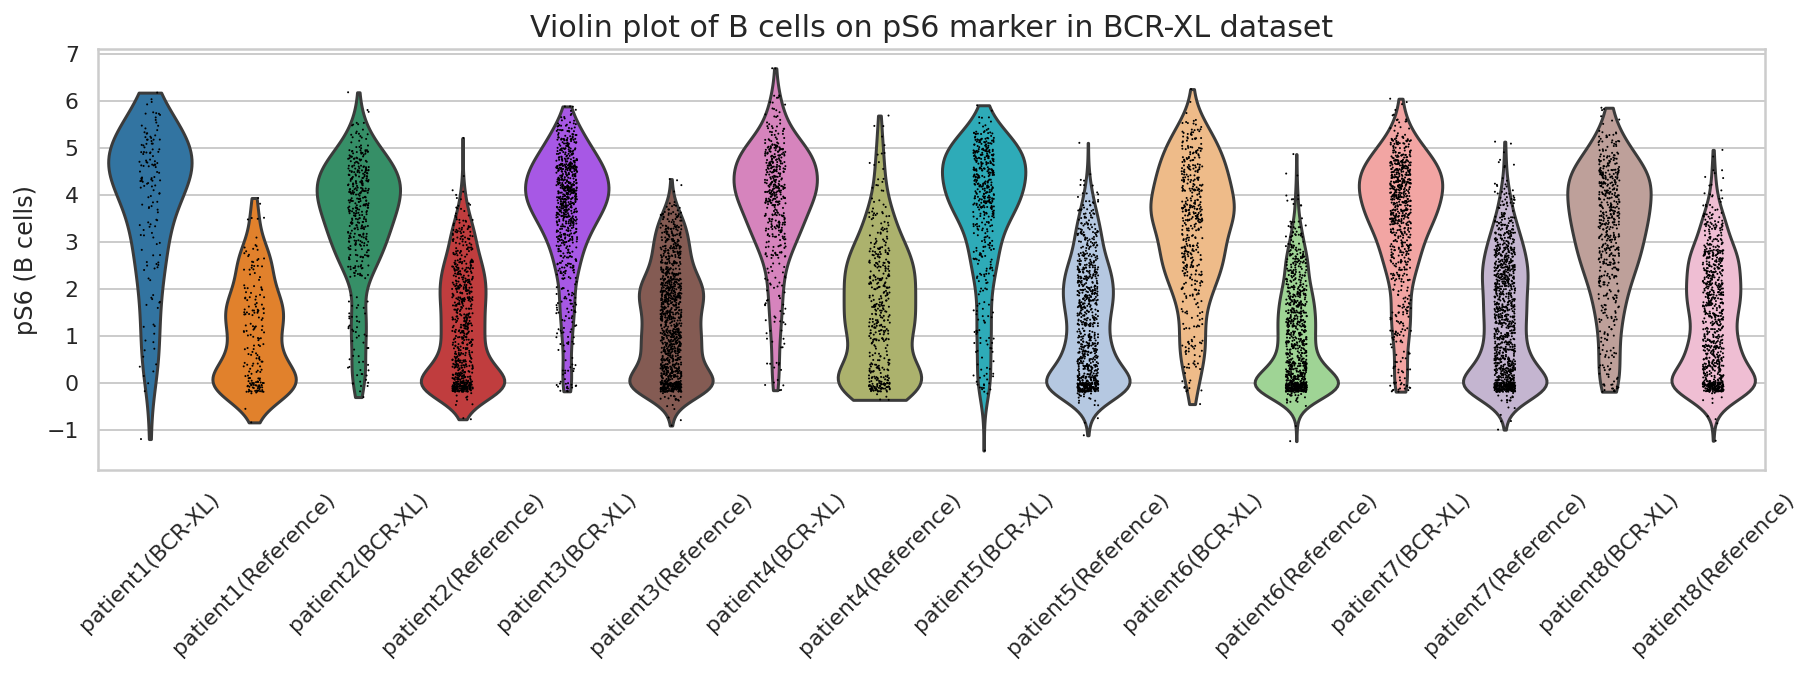

In [15]:
adata_Bcell = adata[(adata.obs['population'] == 'B-cells IgM-') | (adata.obs['population'] == 'B-cells IgM+'),:]
with rc_context({'figure.figsize': (12, 4)}):
    ax = sc.pl.violin(adata_Bcell, ['pS6'], groupby='patient_id', rotation=45, show=False)
    ax.set_ylabel('pS6 (B cells)')
    ax.set_title("Violin plot of B cells on pS6 marker in BCR-XL dataset", fontsize=15)
    plt.show()

### Rank the marker pairs using kNN purity

In [16]:
# calculate the ce score for each marker pair
ce_score_pair = model.rank_markers(adata_list, sample_labels, eval_pair=True, meld_kwargs=meld_kwargs)
### sort the cross entropy score
ce_score_pair = OrderedDict(sorted(ce_score_pair.items(), key=lambda x: x[1]))

Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating

  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusi

Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples a

Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating

  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusion operator...
  Calculating KNN search...
  Calculating affinities...
Building graph on 16 samples and 2 features.
Calculating graph and diffusi

In [17]:
### create data frame
ce_pair_df = defaultdict(list)
for k, v in ce_score_pair.items():
    ce_pair_df['Marker'].append(k)
    ce_pair_df['Cross Entropy'].append(v)
ce_pair_df = pd.DataFrame(ce_pair_df)

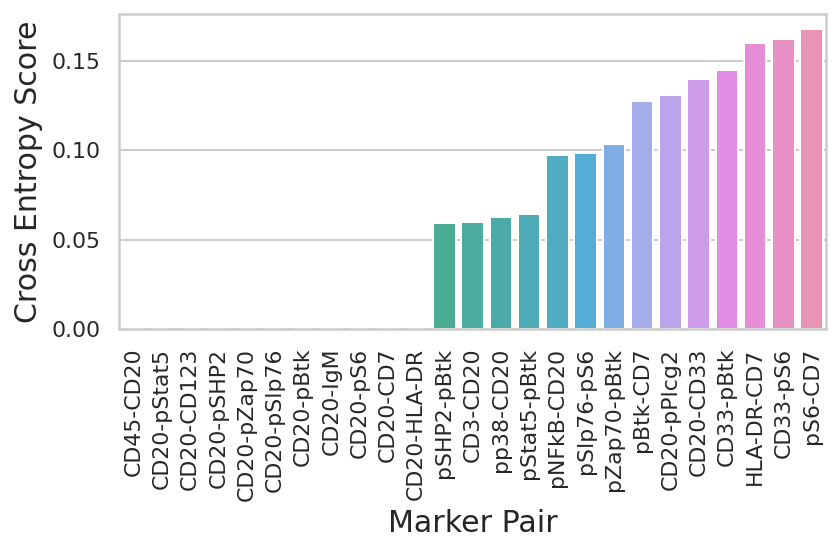

In [18]:
# plot the top 20 marker pairs used to infer cell populations
ax = sns.barplot(x="Marker", y='Cross Entropy', data=ce_pair_df.iloc[:25,:])

ax.set_xlabel("Marker Pair", fontsize=15)
ax.set_ylabel("Cross Entropy Score", fontsize=15)
ax.set_xticklabels(ce_pair_df['Marker'][:25], rotation=90)

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'BCR-XL Dataset')

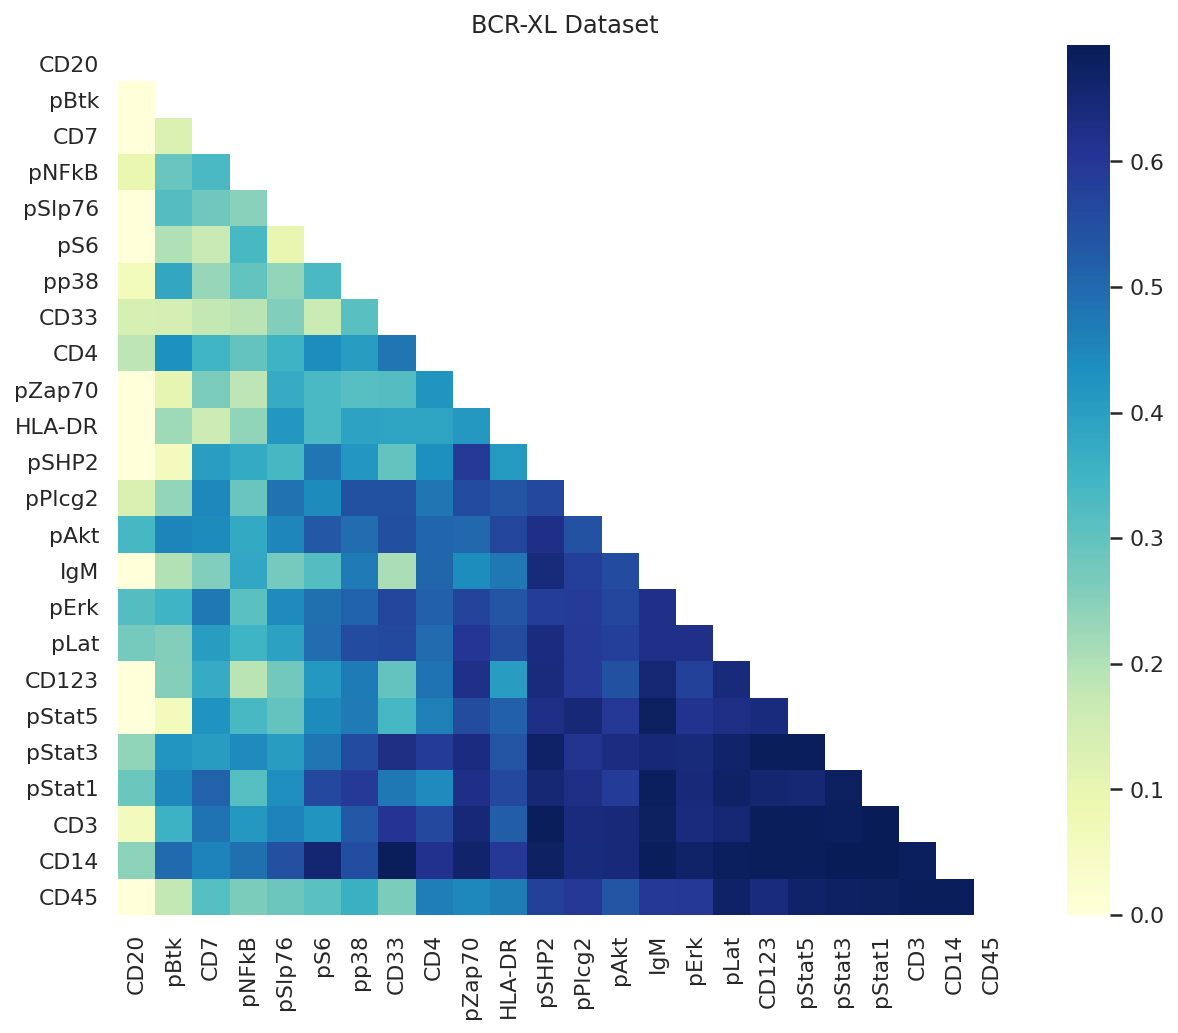

In [19]:
import seaborn as sns
from itertools import combinations

marker_list = list(ce_score.keys())
score_mtx = np.zeros((len(marker_list), len(marker_list)))
mask = np.zeros_like(score_mtx)
mask[np.triu_indices_from(mask)] = True

for m1, m2 in combinations(marker_list, r=2):
    i1, i2 = marker_list.index(m1), marker_list.index(m2)
    k = '-'.join([m1, m2])
    if k in ce_score_pair.keys():
        score_mtx[i1, i2] = ce_score_pair[k]
        score_mtx[i2, i1] = ce_score_pair[k]
    else:
        k = '-'.join([m2, m1])
        score_mtx[i1, i2] = ce_score_pair[k]
        score_mtx[i2, i1] = ce_score_pair[k]

fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sns.heatmap(score_mtx, mask=mask, annot=False, fmt='g', ax=ax,
            cmap='YlGnBu', yticklabels = marker_list, xticklabels = marker_list)
ax.set_title('BCR-XL Dataset')